# Procedure for estimating noise parameters

In [1]:
from __future__ import annotations

from numpy.typing import ArrayLike
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect

import numpy as np
from numpy.random import default_rng

import thztools as thz
from thztools import tdnll

## Simulate measurements
Simulate a set of `m` waveforms, each sampled at `n` time points, with noise parameters
`sigma_alpha`, `sigma_beta`, and `sigma_tau`, and store them in an array `x`. Note that
`x` stores the waveforms in row orientation, with shape `(m, n)`, because NumPy
broadcasting rules and FFT functions are simpler for arrays that are row-oriented.
Measurement waveforms are typically loaded from data files in column orientation,
however, so the `tdnoisefit` function assumes that the data array is column-oriented—this
may be worth changing in a future version.

In [2]:
n = 256  # Number of samples
m = 64  # Number of waveforms
ts = 0.05  # Sampling time [ps]
t0 = 2.5  # Peak pulse time [ps]
fs = 1 / ts  # Sampling frequency [THz]

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2  # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3  # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])

seed = 0  # RNG seed
rng = default_rng(seed)

In [3]:
mu, t = thz.thzgen(n, ts, t0)
sigma_mu = thz.noiseamp(sigma_parms, mu, ts)

# Use broadcasting to generate multiple simulated noisy measurements of y
x = mu + sigma_mu * rng.standard_normal((m, n))

## Fit for the noise parameters

Set the initial guesses `a0` and `eta0` for the amplitudes and delays, respectively, and
estimate the noise parameters from the simulated measurements. Note that we must take the
transpose of `x`, to convert it from row-orientation to column-orientation.

In [4]:
# tdnoisefit expects a column-oriented data array
v0 = np.mean(np.var(x, axis=0)) * np.ones(3)
a0 = np.ones(m)
eta0 = np.zeros(m)
mu0 = np.mean(x, axis=0)
result = thz.tdnoisefit(
    x.T, v0=v0, mu0=mu0, a0=a0, eta0=eta0, ts=ts, fix_v=True, fix_mu=True, fix_a=True, fix_eta=False
)

Optimization terminated successfully.
         Current function value: -86448.398482
         Iterations: 84
         Function evaluations: 273
         Gradient evaluations: 273


In [5]:
eta0 = result[0]["eta"]
mu0 = np.mean(thz.scaleshift(x, eta=-eta0), axis=0)
result = thz.tdnoisefit(
    x.T, v0=v0, mu0=mu0, a0=a0, eta0=eta0, ts=ts, fix_v=True, fix_mu=True, fix_a=False, fix_eta=True
)

Optimization terminated successfully.
         Current function value: -86594.695628
         Iterations: 42
         Function evaluations: 133
         Gradient evaluations: 133


In [6]:
result = thz.tdnoisefit(
    x.T, v0=v0, mu0=mu0, a0=a0, eta0=eta0, ts=ts, fix_v=False, fix_mu=False, fix_a=False, fix_eta=False
)

Optimization terminated successfully.
         Current function value: -118934.551064
         Iterations: 566
         Function evaluations: 1028
         Gradient evaluations: 1028


### Check the variance amplitude estimates

The `tdnoisefit` function returns a tuple with three elements: a dictionary `p` of output
parameters; the value `fval` of the cost function at those parameters; and a dictionary
`diagnostic` that includes additional diagnostic information about the result, including
the parameter uncertainty. Note that noise parameter uncertainty is expressed as a
standard deviation, so the uncertainty in the noise parameters refers to the standard
deviation of the variance amplitude. We apply the Poisson correction to each variance
parameter and its associated uncertainty—that is we multiply each by `m / (m - 1)`.

In [7]:
p_names = ["var_alpha", "var_beta", "var_tau"]
for i in range(3):
    val = result[0]['var'][i] * (m / (m - 1))
    err = result[2]['err']['var'][i] * (m / (m - 1))
    print(f"Estimated {p_names[i]}: {val:.4g} ± {err:.4g}")

Estimated var_alpha: 9.941e-09 ± 1.361e-10
Estimated var_beta: 9.631e-05 ± 3.512e-06
Estimated var_tau: 8.47e-07 ± 6.925e-08


In [8]:
cv = result[2]["cov"]

In [9]:
cv[:3, :3]

array([[ 1.87535330e-04, -2.01357449e-05, -6.17016758e-06],
       [-2.01358442e-05,  1.32961151e-03, -7.24082100e-04],
       [-6.17007206e-06, -7.24082155e-04,  6.68415536e-03]])

In [10]:
result[2]["message"]

'Optimization terminated successfully.'

### Check the noise amplitude estimates

Compare the noise amplitude estimates with their true values, specified in the
simulation. The noise amplitudes are just the square root of the variance amplitudes,
and propagating the error for the noise amplitude uncertainty yields

$$
\sigma^2_{\sigma_k} = \left(\frac{dV_k}{d\sigma_k}\right)^{-2} \sigma^2_{V_k}
= \frac{1}{2\sigma_k} \sigma^2_{V_k}.
$$

In [11]:
p_names = ["sigma_alpha", "sigma_beta", "sigma_tau"]
for i in range(3):
    val = np.sqrt(result[0]['var'][i] * (m / (m - 1)))
    err = 0.5 * result[2]['err']['var'][i] * (m / (m - 1)) / val
    print(f"Estimated {p_names[i]}: {val:.4g} ± {err:.4g}")
for i in range(3):
    val = np.sqrt(result[0]['var'][i] * (m / (m - 1))) / sigma_parms[i]
    err = (
        0.5
        * result[2]['err']['var'][i]
        * (m / (m - 1))
        / (sigma_parms[i] ** 2)
    )
    print(
        f"Estimated {p_names[i]}, relative to true value: {val:.3f} ± {err:.3f}"
    )

Estimated sigma_alpha: 9.97e-05 ± 6.827e-07
Estimated sigma_beta: 0.009814 ± 0.0001789
Estimated sigma_tau: 0.0009204 ± 3.762e-05
Estimated sigma_alpha, relative to true value: 0.997 ± 0.007
Estimated sigma_beta, relative to true value: 0.981 ± 0.018
Estimated sigma_tau, relative to true value: 0.920 ± 0.035


Plot the data

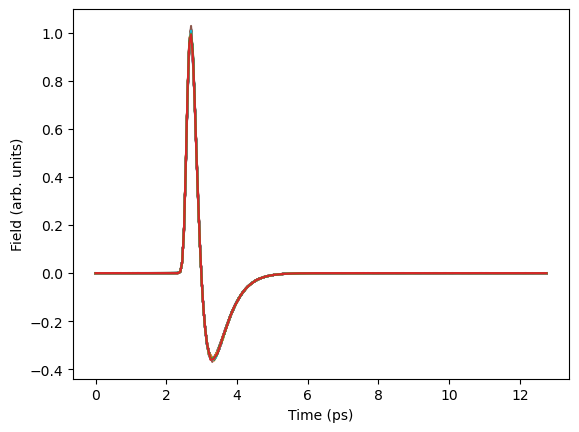

In [12]:
_, ax = plt.subplots()
ax.plot(t, x.T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

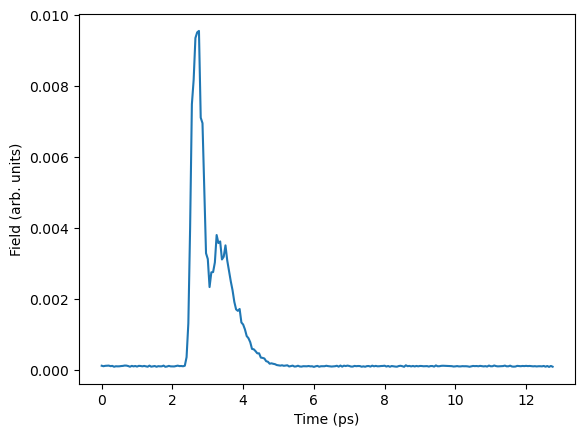

In [13]:
_, ax = plt.subplots()
ax.plot(t, np.std(x, axis=0).T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

## Consider alternative method
Try alternating between minimizing the least-squares portion of the cost function for fixed $\sigma$ and minimizing the log-likelihood as a function of $\sigma$ while holding all other parameters fixed.

In [14]:
from scipy.fft import rfft, irfft, rfftfreq

def lsq_res(p: ArrayLike, x: ArrayLike, log_v: ArrayLike, ts: float) -> ArrayLike:
    p = np.asarray(p)
    x = np.asarray(x)
    log_v = np.asarray(log_v)
    
    m, n = x.shape
    mu = p[:n]
    a = np.concatenate(([1.0], p[n : n + m - 1]))
    eta = np.concatenate(([0.0], p[n + m - 1: n + 2 * (m - 1)]))
    v = np.exp(log_v)

    # Compute frequency vector and Fourier coefficients of mu
    f = rfftfreq(n, ts)
    w = 2 * np.pi * f
    mu_f = rfft(mu)

    exp_iweta = np.exp(1j * np.outer(eta, w))
    zeta_f = ((np.conj(exp_iweta) * mu_f).T * a).T
    zeta = irfft(zeta_f, n=n)

    # Compute residuals and their squares for subsequent computations
    res = x - zeta
    ressq = res**2

    # Alternative case: A, eta, or both are not set to defaults
    dzeta = irfft(1j * w * zeta_f, n=n)

    valpha = v[0]
    vbeta = v[1] * zeta**2
    vtau = v[2] * dzeta**2
    vtot = valpha + vbeta + vtau

    resnormsq = ressq / vtot
    return resnormsq.flatten()

In [15]:
p0 = np.concatenate((mu0, a0[1:], eta0[1:]))
res = lsq_res(p0, x, np.log(v0), ts)

In [16]:
from scipy.optimize import least_squares

out = least_squares(lsq_res, p0, args=(x, np.log(v0), ts))

In [17]:
out

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 7.096e-02  6.408e-02 ...  1.791e-02  1.037e-01]
           x: [-4.309e-04  4.082e-04 ...  1.130e-03 -2.433e-03]
        cost: 15371.544971735677
         jac: [[-3.202e+02 -3.357e-02 ...  0.000e+00 -0.000e+00]
               [-2.925e-02  3.042e+02 ...  0.000e+00 -0.000e+00]
               ...
               [ 4.037e+00 -2.669e+00 ...  0.000e+00  2.575e+00]
               [ 1.998e+01 -9.737e+00 ...  0.000e+00  6.382e+00]]
        grad: [-3.011e-02  3.776e-03 ... -1.070e+00 -2.727e+00]
  optimality: 31.62243319292611
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 18
        njev: 17

In [18]:
def tdnoisefit_lsq(x: ArrayLike, *, v0: ArrayLike, mu0: ArrayLike, a0: ArrayLike, eta0: ArrayLike, ts: float) -> tuple[dict, float, dict]:
    x = np.asarray(x)
    n, m = x.shape
    v0 = np.asarray(v0)
    mu0 = np.asarray(mu0)
    a0 = np.asarray(a0)
    eta0 = np.asarray(eta0)
    
    logv0 = np.ma.log(v0).filled(-np.inf)

    p0 = np.array([])
    p0 = np.concatenate((p0, mu0))
    p0 = np.concatenate((p0, a0[1:] / a0[0]))
    p0 = np.concatenate((p0, eta0[1:] - eta0[0]))
    
    k = 0
    maxiter = 1000
    tdnll0, _ = tdnll(x.T, mu0, logv0, a0, eta0, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)
    while k < maxiter:
        out = least_squares(lsq_res, p0, args=(x.T, logv0, ts))
        p0 = out.x
        mu0 = p0[:n]
        a0 = np.concatenate(([1.0], p0[n: n + m - 1]))
        eta0 = np.concatenate(([0.0], p0[n + m - 1: n + 2 * (m - 1)]))
        def objective(_logv):
            return tdnll(x.T, mu0, _logv, a0, eta0, ts, fix_logv=False, fix_mu=True, fix_a=True, fix_eta=True)
        out = minimize(objective, logv0, jac=True)
        tdnll1 = out.fun
        if tdnll1 < tdnll0:
            logv0 = out.x
            tdnll0 = tdnll1
            k += 1
        else:
            break
    
    p = {}
    p["var"] = np.exp(logv0)
    p["mu"] = mu0
    p["a"] = a0
    p["eta"] = eta0
    
    diagnostic = {
        "grad": out.jac,
        "cov": out.hess_inv,
        "err": {
            "var": np.array([]),
        },
        "success": out.success,
        "status": out.status,
        "message": out.message,
        "nfev": out.nfev,
        "njev": out.njev,
        "nit": out.nit,
    }
    # Propagate error from log(V) to V
    diagnostic["err"]["var"] = np.sqrt(
        np.diag(np.diag(p["var"]) @ diagnostic["cov"][0:3, 0:3])
        @ np.diag(p["var"])
    )

    return p, out.fun, diagnostic

In [19]:
# p, f, d = tdnoisefit_lsq(x.T, v0=v0, mu0=mu0, a0=a0, eta0=eta0, ts=ts)

In [20]:
# p_names = ["var_alpha", "var_beta", "var_tau"]
# for i in range(3):
#     val = result[0]['var'][i] * (m / (m - 1))
#     err = result[2]['err']['var'][i] * (m / (m - 1))
#     print(f"Estimated {p_names[i]}: {val:.4g} ± {err:.4g}")

## Check gradient calculation in tdnll

In [21]:
logv0 = np.log(sigma_parms**2)
val, grad = tdnll(x, mu0, logv0, a0, eta0, ts, fix_logv=False, fix_mu=False, fix_a=False, fix_eta=False)

In [22]:
from scipy.optimize import approx_fprime

grad_logv = approx_fprime(logv0, lambda logv: tdnll(x, mu0, logv, a0, eta0, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0])
grad_mu = approx_fprime(mu0, lambda mu: tdnll(x, mu, logv0, a0, eta0, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0], epsilon=1e-10)
grad_a = approx_fprime(a0, lambda a: tdnll(x, mu0, logv0, a, eta0, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0])
grad_eta = approx_fprime(eta0, lambda eta: tdnll(x, mu0, logv0, a0, eta, ts, fix_logv=True, fix_mu=True, fix_a=True, fix_eta=True)[0])

In [23]:
grad_logv

array([135.05957031,  41.13183594,   1.70800781])

In [24]:
grad[:3]

array([135.05954989,  41.134872  ,   1.70915813])

In [25]:
grad_mu

array([ 1.97193003e+03, -1.51543645e+03,  1.11860572e+03, -6.85395207e+01,
       -1.17273885e+03,  1.84314558e+03, -2.99245585e+03,  2.14509782e+03,
        1.84809323e+01, -8.90140655e+02, -3.00206011e+02,  2.22717063e+03,
       -2.62822141e+03,  1.63636287e+03, -1.57553586e+03,  2.29571015e+03,
       -2.11264705e+03,  9.00326995e+02,  1.06272637e+03, -2.02358933e+03,
        1.29890395e+03,  3.67581379e+02,  6.30097929e+01, -3.32220225e+02,
       -1.83936208e+02, -6.85395207e+02, -2.02271622e+02,  2.20461516e+02,
       -5.84986992e+02,  8.75297701e+02, -7.28905434e+02,  1.22410711e+03,
        2.12166924e+02, -2.79251253e+02,  1.82917574e+02, -8.90286174e+02,
        3.02679837e+02,  4.05707397e+02, -2.39073415e+03,  2.15863110e+03,
       -1.28333340e+03,  2.22207746e+03, -1.74535671e+03,  7.59901013e+02,
       -9.87056410e+02,  1.00582838e+03, -1.19558536e+03,  6.77886419e+03,
        2.12923624e+03,  4.84578771e+02,  4.72937206e+02,  2.91038280e-01,
        1.79716138e+02, -

In [26]:
grad[3: 3 + n]

array([ 1.97191638e+03, -1.51561831e+03,  1.11826647e+03, -6.88051323e+01,
       -1.17293733e+03,  1.84262909e+03, -2.99307852e+03,  2.14468485e+03,
        1.78492141e+01, -8.91015323e+02, -3.00744802e+02,  2.22677879e+03,
       -2.62838890e+03,  1.63626957e+03, -1.57612694e+03,  2.29532151e+03,
       -2.11307452e+03,  8.99913192e+02,  1.06229543e+03, -2.02451117e+03,
        1.29847774e+03,  3.67281020e+02,  6.22619203e+01, -3.32748455e+02,
       -1.84069116e+02, -6.85940342e+02, -2.02922843e+02,  2.20092870e+02,
       -5.85489871e+02,  8.75024364e+02, -7.29251086e+02,  1.22333300e+03,
        2.12111243e+02, -2.79524349e+02,  1.82307315e+02, -8.91527056e+02,
        3.02132639e+02,  4.05073610e+02, -2.39137939e+03,  2.15836455e+03,
       -1.28399520e+03,  2.22189842e+03, -1.74586790e+03,  7.59311700e+02,
       -9.87787773e+02,  1.00530623e+03, -1.19623007e+03,  6.77820283e+03,
        2.12897200e+03,  4.84384572e+02,  4.72954072e+02,  1.88747067e-01,
        1.79918424e+02, -

In [27]:
grad_a[1:]

array([  -65.41601562, -1144.01953125,   489.81347656,  2632.90820312,
         748.91601562,   -26.21582031, -1161.38574219,  -680.50390625,
         -68.11816406,  -580.37988281,  -507.89355469,   345.68164062,
        -494.09277344,  -391.53613281, -1155.75292969,   284.35351562,
        -328.78613281,   390.17578125,   829.64453125,  -168.68945312,
        -902.78515625,  -626.90039062,  1493.68261719,   763.45507812,
       -1074.58886719,  -347.75488281,  -410.97070312,   459.44335938,
       -1764.48730469,  -449.99316406,  -362.63867188,  -255.29003906,
         859.87988281,   589.02734375,   815.42773438,   960.30761719,
         451.16015625,   265.25      ,  -776.45214844,  -404.79785156,
         854.98339844,  -712.55957031,  1418.63867188,  -199.02441406,
         281.64160156,  -149.48828125,  1037.77441406,  -347.24804688,
          29.68847656,   312.21191406,  -887.89550781,  -612.70605469,
         682.02929688,  1292.85253906,   439.5625    ,  -695.36132812,
      

In [28]:
grad[3 + n : 3 + n + m - 1]

array([  -65.41894563, -1144.02071759,   489.81277419,  2632.90618019,
         748.91435294,   -26.21695026, -1161.38798946,  -680.50545336,
         -68.11989964,  -580.38199778,  -507.89415733,   345.68079731,
        -494.09431231,  -391.53774984, -1155.75482175,   284.35144783,
        -328.78920437,   390.17383825,   829.64390828,  -168.69180432,
        -902.78716675,  -626.90296675,  1493.68004385,   763.45354729,
       -1074.59203604,  -347.75729683,  -410.97347249,   459.44120635,
       -1764.49036924,  -449.9953213 ,  -362.64056989,  -255.29204881,
         859.8787997 ,   589.02505341,   815.42689496,   960.30600729,
         451.15802602,   265.24816972,  -776.45351331,  -404.79979442,
         854.98076472,  -712.56314972,  1418.63705901,  -199.02673366,
         281.63972787,  -149.49024569,  1037.77429346,  -347.25001284,
          29.68668465,   312.2103932 ,  -887.89805618,  -612.7079155 ,
         682.02806724,  1292.84943307,   439.56000407,  -695.36358219,
      

In [29]:
grad_eta[1:]

array([-2464.87792969,   599.57617188,  -702.46191406,  1360.484375  ,
        -981.46386719,  6499.46484375, -3640.57324219,  -227.47949219,
        2727.27050781, -1053.14257812, -1166.37109375,  2760.46777344,
       -5298.58300781,  4757.67578125,  -776.1015625 , -2798.58691406,
       -2818.65917969,  3184.68847656, -7679.95117188,   408.35253906,
        1476.24023438,  -205.99609375, -4405.59960938,  5118.14453125,
       -1826.10253906,  1527.38476562, -4405.15039062, -1860.296875  ,
       -4203.97265625,  -633.2265625 , -1270.00390625,  5272.47558594,
       -1255.25585938,   431.67089844,   508.90625   ,  3241.953125  ,
        -203.63378906,  2622.5703125 ,  -229.37695312,  1241.81933594,
        1363.99609375, -3176.52929688,  4424.67773438, -4184.95898438,
        2553.9453125 , -8475.04101562,  3985.56054688, -5853.15527344,
        2123.39257812,    96.50976562, -4328.81933594, -2330.05761719,
          13.97167969,  2626.60546875,  3242.99707031, -7229.77246094,
      

In [30]:
grad[3 + n + m - 1 : 3 + n + 2 * (m - 1)]

array([-2.46495042e+03,  5.99504871e+02, -7.02532728e+02,  1.36041249e+03,
       -9.81534678e+02,  6.49939131e+03, -3.64064489e+03, -2.27551517e+02,
        2.72719754e+03, -1.05321424e+03, -1.16644214e+03,  2.76039631e+03,
       -5.29865458e+03,  4.75760140e+03, -7.76175052e+02, -2.79865859e+03,
       -2.81873052e+03,  3.18461664e+03, -7.68002185e+03,  4.08280893e+02,
        1.47616658e+03, -2.06068526e+02, -4.40566965e+03,  5.11807296e+03,
       -1.82617611e+03,  1.52731115e+03, -4.40522120e+03, -1.86036724e+03,
       -4.20404256e+03, -6.33300000e+02, -1.27007711e+03,  5.27240300e+03,
       -1.25532815e+03,  4.31600974e+02,  5.08836421e+02,  3.24188146e+03,
       -2.03705473e+02,  2.62249844e+03, -2.29448312e+02,  1.24174814e+03,
        1.36392616e+03, -3.17659878e+03,  4.42460562e+03, -4.18503241e+03,
        2.55387174e+03, -8.47511198e+03,  3.98548832e+03, -5.85322357e+03,
        2.12332192e+03,  9.64368791e+01, -4.32889071e+03, -2.33013044e+03,
        1.39004845e+01,  